In [1]:
import numpy as np

import matplotlib.pyplot as plt

from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

from scipy.signal.windows import dpss

from tqdm import tqdm

# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[38]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)



In [7]:
dchi = np.mean(np.diff(chis_resample))

In [8]:
M = len(eHIeHI)
NW = (chimax - chimin) * Lambda / (2 * np.pi) 
   # window lenght * band width

v = dpss(M = M,
         NW = NW,
         Kmax = 10, sym = False)

v_k = np.fft.rfft(v)
k = 2*np.pi*np.fft.rfftfreq(len(v[0]), d = dchi)

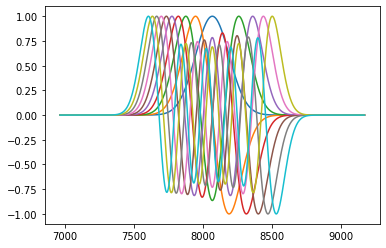

In [9]:
plt.plot(chis_resample[window], v.T/np.max(v, axis=1))

[]

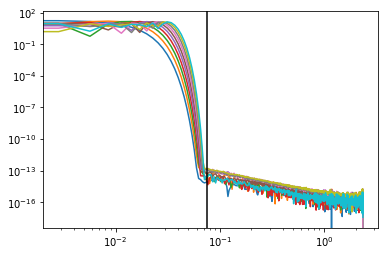

In [10]:
plt.plot(k, np.abs(v_k.T))

plt.axvline(Lambda, c='k')
plt.xscale('log')
plt.loglog()

# computing snr per mode

In [11]:
d = IHi_kappa_windowed

In [12]:
L = np.linalg.cholesky(eHIeHI)
y = np.linalg.solve(L, d.T)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', d, x)

LinAlgError: Matrix is not positive definite

In [13]:
eigval, eigvec = np.linalg.eig(eHIeHI)
print(np.where(eigval < 0.0))
eigval_clean = np.maximum(eigval, 0)
invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
x = eigvec @ invcov @ eigvec.T @ d.T
res1_2 = np.einsum('ij, ji->i', d, x)

(array([ 1,  3, 11, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38,
       44, 46, 47, 48, 49, 50, 51, 52]),)


/tmp/ipykernel_32209/813980654.py:4: RuntimeWarning: divide by zero encountered in divide
  invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


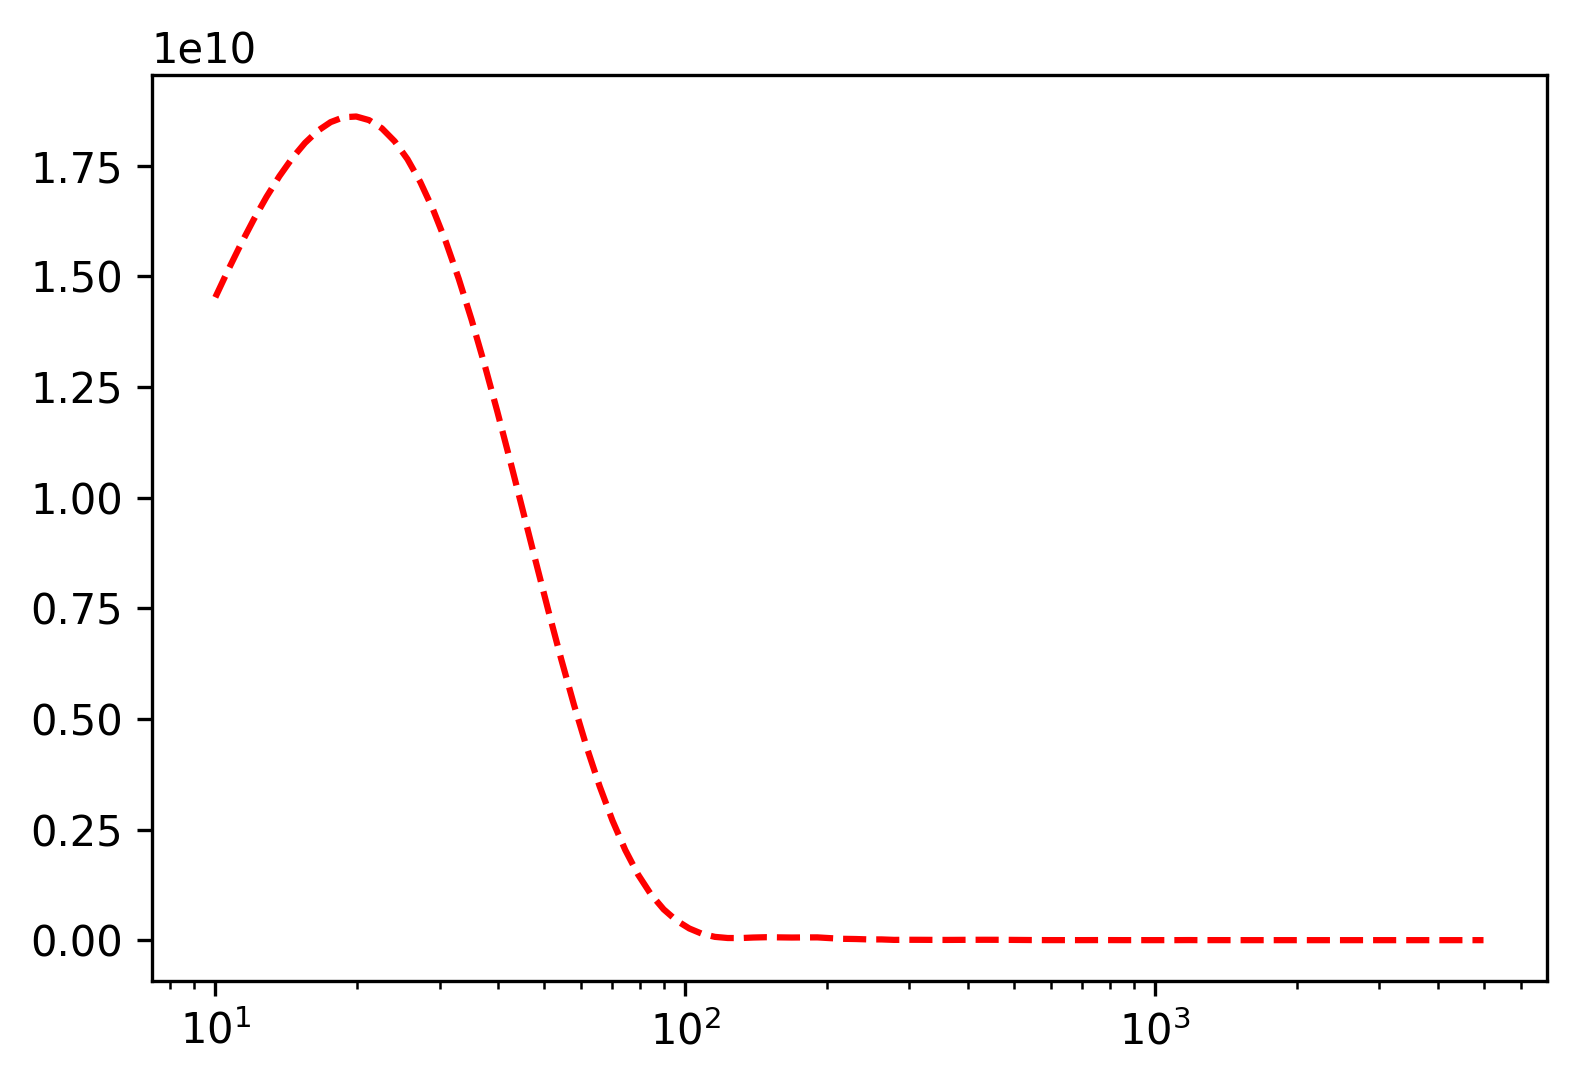

In [14]:
plt.figure(dpi = 300)
# plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res1_2, 'r--')
plt.legend(frameon=False)
plt.xscale('log')

In [15]:
D = np.diag(chis_resample[window])
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))

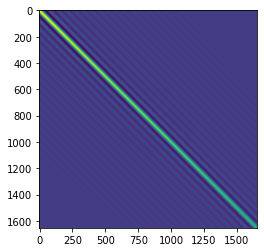

In [16]:
plt.imshow((eIeLO + eLOeI) )

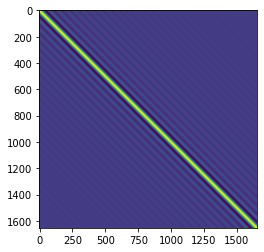

In [17]:
plt.imshow(D @(eIeLO + eLOeI) @ D)

In [18]:
print(np.diag(D @ eHIeHI @ D))

[1. 1. 1. ... 1. 1. 1.]


In [19]:
D = np.diag(chis_resample[window])
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
x = np.linalg.solve(L.T, y) 
res2 = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x )

LinAlgError: Matrix is not positive definite

In [26]:
D = np.diag(chis_resample[window])

eigval, eigvec = np.linalg.eig(D @ eHIeHI @ D)
print(np.where(eigval < 0.0))
eigval_clean = np.maximum(eigval, 0)
invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
x = eigvec @ invcov @ eigvec.T @ D @ d.T
res2_2 = np.einsum('ij, ji->i', d @ D, x)

(array([26, 29, 41, 46, 47, 48, 49, 50, 54, 55, 56, 57, 58, 61, 62, 63, 64,
       68, 70, 71, 73, 74, 76, 77, 78]),)


/tmp/ipykernel_32209/1380094881.py:6: RuntimeWarning: divide by zero encountered in divide
  invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
/tmp/ipykernel_32209/1380094881.py:6: RuntimeWarning: invalid value encountered in divide
  invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))


In [20]:
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, D @ IHi_kappa_windowed.T )
x = np.linalg.solve(L.T, y) 
res3 = np.einsum('ij, ji->i', IHi_kappa_windowed @ D, x )

LinAlgError: Matrix is not positive definite

In [21]:
eigval, eigvec = np.linalg.eig(D @ eHIeHI @ D)
print(np.where(eigval < 0.0))
eigval_clean = np.maximum(eigval, 0)
invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
x = eigvec @ invcov @ eigvec.T @ D @ d.T
res3_2 = np.einsum('ij, ji->i', d @ D, x)

(array([ 2,  4, 23, 28, 29, 30, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46,
       57, 58, 59, 60, 61, 62, 63, 64]),)


/tmp/ipykernel_32209/2375543945.py:4: RuntimeWarning: divide by zero encountered in divide
  invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


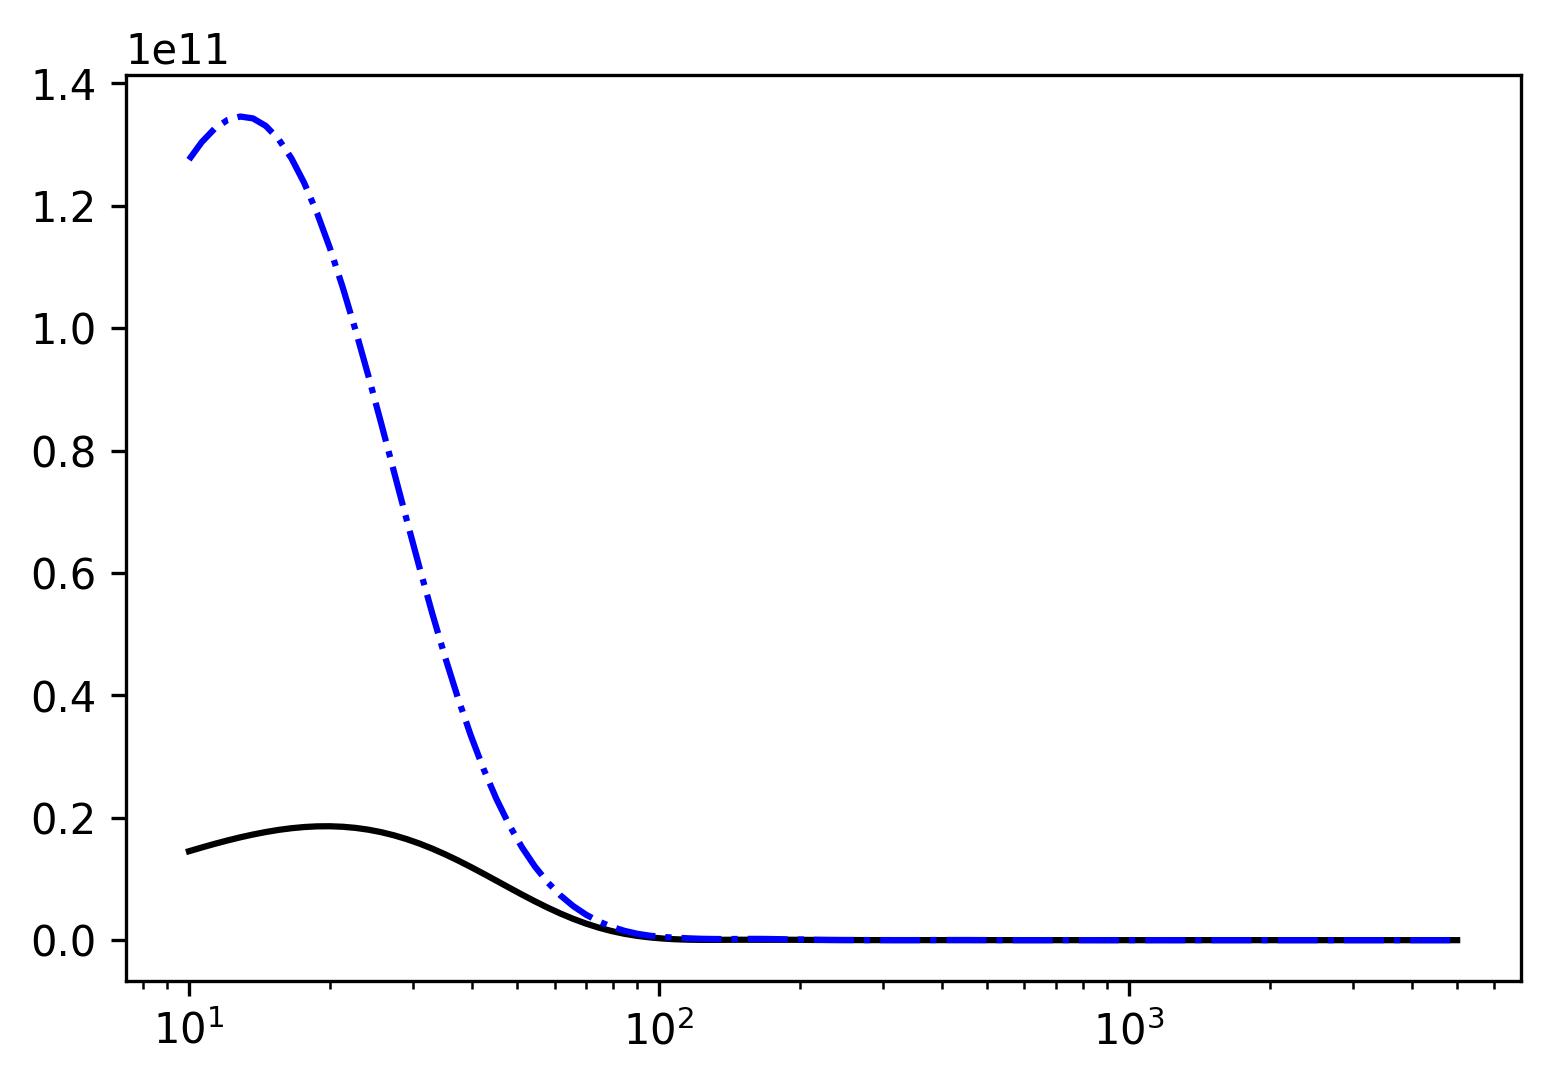

In [22]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1_2, 'k')
# plt.plot(ells, ells**2 * res3, 'r--')
plt.plot(ells, ells**2 * res3_2, 'b-.')

plt.legend(frameon=False)
plt.xscale('log')

In [23]:
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))

cov = D @ eHIeHI @ D
M = len(cov)
NW = (chimax - chimin) * Lambda / (2 * np.pi)    
Kmax = max(1, int(min(2 * NW * M, M)))
v = dpss(M = M,
         NW = NW,
         Kmax = Kmax)

print(v.shape, cov.shape, v.T.shape)
cov_dpss = v @ cov @ v.T
d_dpss = v @ D @ IHi_kappa_windowed.T

L = np.linalg.cholesky(cov_dpss)
y = np.linalg.solve(L, d_dpss)
x = np.linalg.solve(L.T, y) 
res4 = np.einsum('ij, ji->i', d_dpss.T , x )

(1652, 1652) (1652, 1652) (1652, 1652)


LinAlgError: Matrix is not positive definite

In [30]:
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))

cov = D @ eHIeHI @ D
M = len(cov)
NW = (chimax - chimin) * Lambda / (2 * np.pi)    
Kmax = max(1, int(min(2 * NW * M, M)))
v = dpss(M = M,
         NW = NW,
         Kmax = Kmax)

print(v.shape, cov.shape, v.T.shape)
cov_dpss = v @ cov @ v.T
d_dpss = v @ D @ IHi_kappa_windowed.T



intermediate = np.linalg.solve(cov_dpss, d_dpss)
res5 = np.einsum('ij, ji->i', d_dpss.T , intermediate )

(1652, 1652) (1652, 1652) (1652, 1652)


In [24]:
D = np.diag(1/np.sqrt(np.diag(eHIeHI)))

cov = D @ eHIeHI @ D
M = len(cov)
NW = (chimax - chimin) * Lambda / (2 * np.pi)    
Kmax = max(1, int(min(2 * NW * M, M)))
v = dpss(M = M,
         NW = NW,
         Kmax = Kmax)

print(v.shape, cov.shape, v.T.shape)
cov_dpss = v @ cov @ v.T
d_dpss = v @ D @ IHi_kappa_windowed.T

eigval, eigvec = np.linalg.eig(cov_dpss)
print(np.where(eigval < 0.0))
eigval_clean = np.maximum(eigval, 0)
invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))
x = eigvec @ invcov @ eigvec.T @ d_dpss
res4_2 = np.einsum('ij, ji->i', d_dpss.T, x)


(1652, 1652) (1652, 1652) (1652, 1652)
(array([ 2,  5, 14, 19, 20, 21, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 38,
       41, 45, 47, 49, 50, 51, 52, 60, 61]),)


/tmp/ipykernel_32209/4017367592.py:18: RuntimeWarning: divide by zero encountered in divide
  invcov = np.diag(np.where(eigval_clean == 0, 0.0, 1 /eigval_clean))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


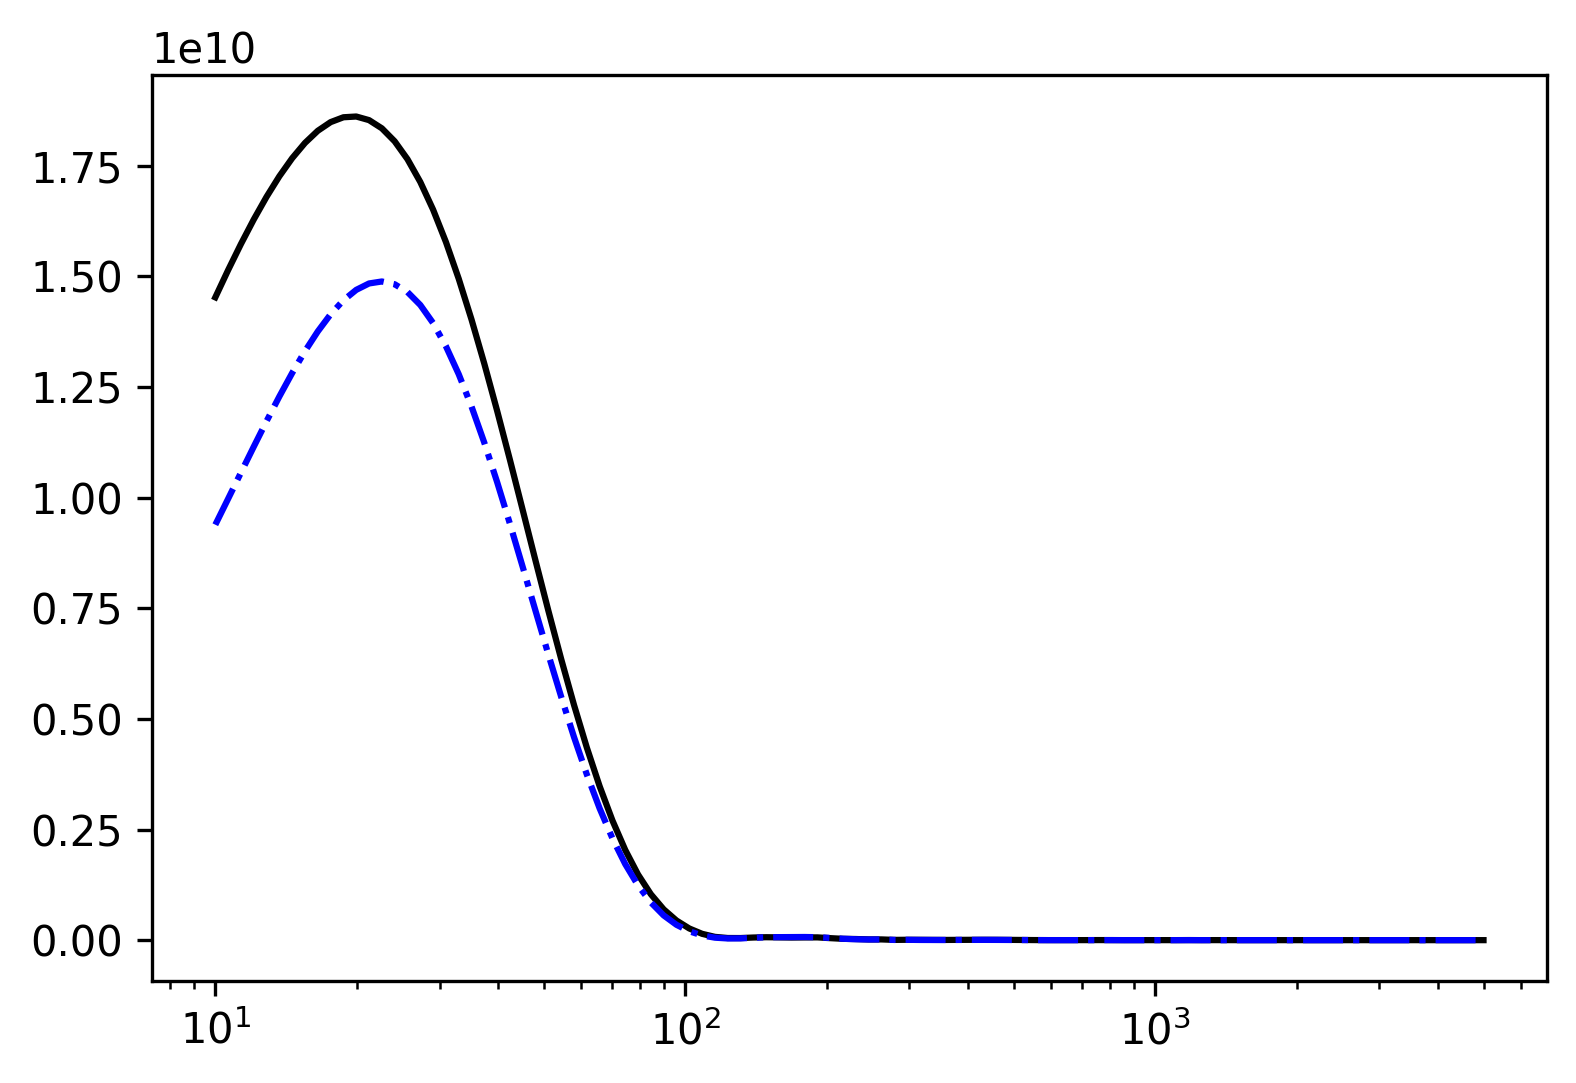

In [32]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1_2, 'k')
# plt.plot(ells, ells**2 * res5, 'r--')
plt.plot(ells, ells**2 * res4_2, 'b-.')

plt.legend(frameon=False)
plt.xscale('log')